## About

This is sentiment analysis NLP project for ISY501 course offered at Torrens University Australia. The dataset used for training is downloaded from: https://www.cs.jhu.edu/~mdredze/datasets/sentiment/index2.html

# Installing dependencies & Defining imports

Apart from the core Python 3, please ensure the following packages have been installed:


*   nltk==3.8.1
*   tensorflow==2.14.0

In [24]:
# we use requests to download dataset
!pip install requests

import os
import requests
import tarfile
import re
import io
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Defining constants

In [18]:
DATASET_URL = 'https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz'
DATASET_EXTRACTED_PATH = '/content/dataset_extracted'

# Create local dir to put extracted dataset
!mkdir -p {DATASET_EXTRACTED_PATH}

REVIEW_DOMAINS = ["books", "dvd", "electronics", "kitchen_&_housewares"]
REVIEW_DOMAINS_PATH = '{}/sorted_data_acl'.format(DATASET_EXTRACTED_PATH)

MODEL_CHECKPOINT_PATH="./checkpoint"
MODEL_SAVE_FILE_PATH="sentiment_analyzer.h5"
MODEL_PREPROCESSING_INFO_FILE_PATH="preprocessing_info.pkl"

# Getting dataset Locally

In [7]:
# Download and extract the dataset
print("Downloading dataset...")
response = requests.get(DATASET_URL)
print("Download completed!")

with tarfile.open(fileobj=io.BytesIO(response.content), mode='r:gz') as tar:
    tar.extractall(path=DATASET_EXTRACTED_PATH)
    print("Dataset has been extracted successfully and saved locally in path: {}".format(DATASET_EXTRACTED_PATH))

Download completed!
Dataset has been extracted successfully and saved locally in path: /content/dataset_extracted


# Load training data

In [8]:
# Review text cleaning function
def clean_review_text(text: str) -> list:
    # Remove <review_text> at start and </review_text> at end
    sentence = re.sub(r'<review_text>', '', text)
    sentence = re.sub(r'</review_text>', '', sentence)

    # Remove punctuations
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Convert to lowercase and tokenize
    tokens = word_tokenize(sentence.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return lemmatized_tokens


# load dataset function
def load_dataset():
    regex_review = re.compile(r'<review_text>(.*?)<\/review_text>', flags=re.DOTALL)
    reviews = []
    labels = []

    print("Reading train data...")
    for domain in REVIEW_DOMAINS:
        domain_path = os.path.join(REVIEW_DOMAINS_PATH, domain)

        positive_reviews_file = os.path.join(domain_path, "positive.review")
        negative_reviews_file = os.path.join(domain_path, "negative.review")

        print("Reading positive reviews for {}...".format(domain))
        with open(positive_reviews_file, 'r', encoding="utf-8") as file:
            file_content = file.read()
            positive_reviews = re.findall(regex_review, file_content)

            print("Found {} reviews\n".format(len(positive_reviews)))
            for review in positive_reviews:
                reviews.append(clean_review_text(review))
                labels.append(1)

        print("Reading negative reviews for {}...".format(domain))
        with open(negative_reviews_file, 'r', encoding="utf-8") as file:
            file_content = file.read()
            negative_reviews = re.findall(regex_review, file_content)

            print("Found {} reviews\n".format(len(negative_reviews)))
            for review in negative_reviews:
                reviews.append(clean_review_text(review))
                labels.append(0)

    return reviews, labels



Reading train data...
Reading positive reviews for books...
Found 1000 reviews

Reading negative reviews for books...
Found 1000 reviews

Reading positive reviews for dvd...
Found 1000 reviews

Reading negative reviews for dvd...
Found 1000 reviews

Reading positive reviews for electronics...
Found 1000 reviews

Reading negative reviews for electronics...
Found 1000 reviews

Reading positive reviews for kitchen_&_housewares...
Found 1000 reviews

Reading negative reviews for kitchen_&_housewares...
Found 1000 reviews

Here's an example pre-processed data:
Review[0]: ['sphere', 'michael', 'crichton', 'excellant', 'novel', 'certainly', 'hardest', 'put', 'crichton', 'novel', 'read', 'story', 'revolves', 'around', 'man', 'named', 'norman', 'johnson', 'johnson', 'phycologist', 'travel', '4', 'civilans', 'remote', 'location', 'pacific', 'ocean', 'help', 'navy', 'top', 'secret', 'misssion', 'quickly', 'learn', 'ocean', 'half', 'mile', 'long', 'spaceship', 'civilans', 'travel', 'center', '1000

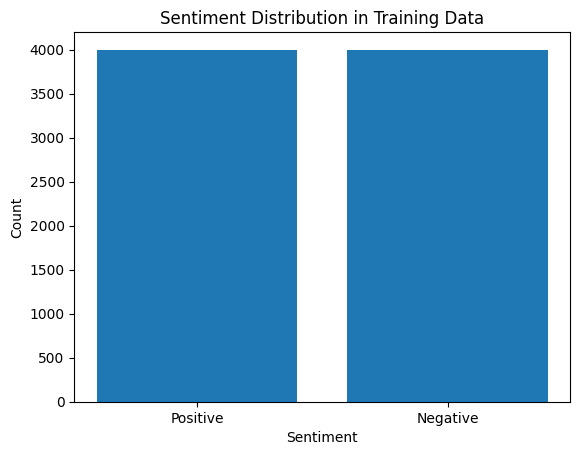

In [14]:
# LOAD dataset (Note we tokenize review texts and use binary encoding for labels: 1 for positive, 0 for negative)
reviews, labels = load_dataset()

print("Here's an example pre-processed data:")
print("Review[0]: {}".format(reviews[0]))
print("Label[0]: {}".format(labels[0]))


# Shuffle data
reviews, labels = shuffle(reviews, labels, random_state=42)

# Visualize sentiment distribution
positive_count = sum(labels)
negative_count = len(labels) - positive_count
plt.bar(['Positive', 'Negative'], [positive_count, negative_count])
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Getting data ready for training

In [16]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
vocab_size = len(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(reviews)
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(padded_sequences) * split_ratio)
x_train, y_train = padded_sequences[:split_index], np.array(labels)[:split_index]
x_test, y_test = padded_sequences[split_index:], np.array(labels)[split_index:]

# Defining the training model

In [17]:
# Model configuration
embedding_dim = 100

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1854, 100)         4193900   
                                                                 
 bidirectional (Bidirection  (None, 1854, 128)         84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4319661 (16.48 MB)
Trainable params: 4319661 (16.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the model & saving it

In [20]:
# Save weights directory
!mkdir -p {MODEL_CHECKPOINT_PATH}
checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_PATH)

# Train the model
batch_size = 16
history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=5, validation_split=0.2, callbacks=[checkpoint], verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

model.save(MODEL_SAVE_FILE_PATH)

# Save preprocessing parameters
preprocessing_info = {
    "max_len": max_len,
    "word_index": tokenizer.word_index,
    "num_words": tokenizer.num_words
}

with open(MODEL_PREPROCESSING_INFO_FILE_PATH, "wb") as pkl_file:
    pickle.dump(preprocessing_info, pkl_file)

Epoch 1/5
320/320 [==============================] - 154s 455ms/step - loss: 0.5796 - accuracy: 0.6740 - val_loss: 0.4918 - val_accuracy: 0.7734
Epoch 2/5
320/320 [==============================] - 131s 410ms/step - loss: 0.2317 - accuracy: 0.9102 - val_loss: 0.5625 - val_accuracy: 0.7750
Epoch 3/5
320/320 [==============================] - 116s 361ms/step - loss: 0.0682 - accuracy: 0.9799 - val_loss: 0.7595 - val_accuracy: 0.7648
Epoch 4/5
320/320 [==============================] - 93s 290ms/step - loss: 0.0323 - accuracy: 0.9926 - val_loss: 0.7550 - val_accuracy: 0.7602
Epoch 5/5
50/50 [==============================] - 7s 106ms/step - loss: 1.1405 - accuracy: 0.7325
Test Accuracy: 73.25%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Loading saved model

In [25]:
def load_saved_model(model_file_path, preprocessing_info_file_path):
    # Load preprocessing parameters
    with open(preprocessing_info_file_path, "rb") as pkl_file:
        preprocessing_info = pickle.load(pkl_file)

    tokenizer = Tokenizer()
    tokenizer.word_index = preprocessing_info['word_index']
    tokenizer.num_words = preprocessing_info['num_words']
    max_len = preprocessing_info["max_len"]

    # Load & return model
    return load_model(model_file_path), preprocessing_info, tokenizer


In [28]:
model, preprocessing_info, tokenizer = load_saved_model(MODEL_SAVE_FILE_PATH, MODEL_PREPROCESSING_INFO_FILE_PATH)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1854, 100)         4193900   
                                                                 
 bidirectional (Bidirection  (None, 1854, 128)         84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4319661 (16.48 MB)
Trainable params: 4319661 (16.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Using saved model to make predictions

In [29]:
def predict(review_texts: list) -> list:
    # Clean and preprocess each review text
    preprocessed_reviews = [clean_review_text(text) for text in review_texts]

    # Convert preprocessed text to sequences using the tokenizer used during training
    sequences = tokenizer.texts_to_sequences(preprocessed_reviews)

    # Pad sequences to have consistent length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Make predictions using the loaded model
    predictions = model.predict(padded_sequences)

    # Convert predictions to a list and get only first value from result item
    prediction_values = [item[0] for item in predictions.tolist()]

    results = []
    for i, prediction in enumerate(prediction_values):
      label = 'Positive' if prediction > 0.5 else 'Negative'
      input_text = review_texts[i]
      accuracy = round(float(prediction), 8)

      result_dict = { 'label': label, 'accuracy': accuracy, 'input_text': input_text }
      results.append(result_dict)


    return results

In [30]:
# Testing on sample data
reviews = [
    "This was a good product. The person it was bought for loved it. Got lots of use out of it.",
    "I returned above item because it doesn't work with me MacBook Pro. I have not received my refund yet. Please double check why my refund takes so long. Thank you."
]

predict(reviews)

1/1 [==============================] - 2s 2s/step


[{'label': 'Positive',
  'accuracy': 0.99811649,
  'input_text': 'This was a good product. The person it was bought for loved it. Got lots of use out of it.'},
 {'label': 'Negative',
  'accuracy': 0.00168357,
  'input_text': "I returned above item because it doesn't work with me MacBook Pro. I have not received my refund yet. Please double check why my refund takes so long. Thank you."}]